In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot

In [2]:
print(tf.config.list_physical_devices('GPU'))
mnist = keras.datasets.mnist

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.__version__

'2.8.0'

In [4]:
mnist

<module 'keras.api._v2.keras.datasets.mnist' from '/Users/hardik/miniforge3/lib/python3.9/site-packages/keras/api/_v2/keras/datasets/mnist/__init__.py'>

In [5]:
(x_train_temp,y_train),(x_test_temp,y_test) = mnist.load_data()

In [6]:
x_train_temp.shape

(60000, 28, 28)

In [7]:
x_train = np.empty((60000, 32, 32))

In [8]:
x_test = np.empty((10000, 32, 32))

In [9]:

for index in tqdm( range( len(x_train_temp))):
  x_train[index] =  np.pad(x_train_temp[index], [(0, 4), (0, 4)], mode='constant')

for index in tqdm( range( len(x_test_temp))):
  x_test[index] =  np.pad(x_test_temp[index], [(0, 4), (0, 4)], mode='constant')

100%|██████████| 10000/10000 [00:00<00:00, 67466.92it/s]


In [10]:
d = x_test[0]
print(d.shape)

(32, 32)


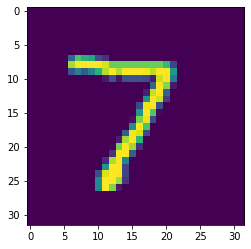

In [11]:
plt.imshow(x_test[0])

In [12]:

# x_train = keras.utils.normalize(x_train,axis=1)
# x_test = keras.utils.normalize(x_test,axis=1)

model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
# output
model.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train,y_train, epochs=3)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-24 13:10:50.878418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-24 13:10:50.878549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/3


2022-12-24 13:10:51.221671: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-24 13:10:51.377320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 2.0696 - accuracy: 0.3509
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 1.1633 - accuracy: 0.5441
Epoch 3/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8296 - accuracy: 0.7157


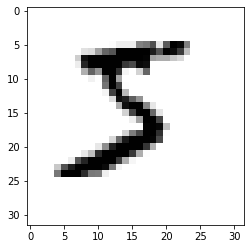

In [13]:
plt.imshow(x_train[0], plt.cm.binary)

In [14]:
val_loss, val_acc = model.evaluate(x_test,y_test)

 20/313 [>.............................] - ETA: 1s - loss: 0.7184 - accuracy: 0.7844

2022-12-24 13:11:21.455085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step - loss: 0.6957 - accuracy: 0.7743


In [15]:
print(val_loss, val_acc)

0.6956560015678406 0.7743000388145447


## Model Quantization (Quantization aware training)

In [17]:
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

In [18]:
q_aware_model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (QuantizeL  (None, 32, 32)           3         
 ayer)                                                           
                                                                 
 quant_flatten (QuantizeWrap  (None, 1024)             1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 16)               16405     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 16)               277       
 perV2)                                                          
                                                                 
 quant_dense_2 (QuantizeWrap  (None, 10)               1

In [20]:
q_aware_model.fit(x_train,y_train, epochs = 3)

Epoch 1/3
1875/1875 [==============================] - 26s 14ms/step - loss: 0.6456 - accuracy: 0.7779
Epoch 2/3
1875/1875 [==============================] - 25s 13ms/step - loss: 0.5887 - accuracy: 0.8034
Epoch 3/3
1875/1875 [==============================] - 24s 13ms/step - loss: 0.5470 - accuracy: 0.8301


In [21]:
q_aware_model.evaluate(x_test,y_test)

 14/313 [>.............................] - ETA: 2s - loss: 0.4581 - accuracy: 0.8527

2022-12-24 13:17:39.443357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 0.5349 - accuracy: 0.8395


[0.5349469780921936, 0.8395000696182251]

In [59]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((x_train)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

In [60]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

In [61]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gq/309vcw9507z_fp220k0ltqy80000gn/T/tmpfe61hctx/assets


INFO:tensorflow:Assets written to: /var/folders/gq/309vcw9507z_fp220k0ltqy80000gn/T/tmpfe61hctx/assets
/Users/hardik/miniforge3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-24 13:51:14.947119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-12-24 13:51:14.947132: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-12-24 13:51:14.947206: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gq/309vcw9507z_fp220k0ltqy80000gn/T/tmpfe61hctx
2022-12-24 13:51:14.948674: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-12-24 13:51:14.948680: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if prese

In [63]:
q_aware_model.save('../data/quantized_mnist_new')

INFO:tensorflow:Assets written to: ../data/quantized_mnist_new/assets


INFO:tensorflow:Assets written to: ../data/quantized_mnist_new/assets


In [66]:
with open ("../data/quantized_mnist.tflite", 'wb') as f:
  f.write(tflite_quant_model)

In [69]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_path='../data/quantized_mnist.tflite')
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_flatten_input:0
shape: [ 1 32 32]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.int8'>


## Test ground

In [14]:
new_model = keras.models.load_model('../data/hand_written_model')

In [15]:
predictions = new_model.predict([x_test])

313/313 [==============================] - 1s 3ms/step


4


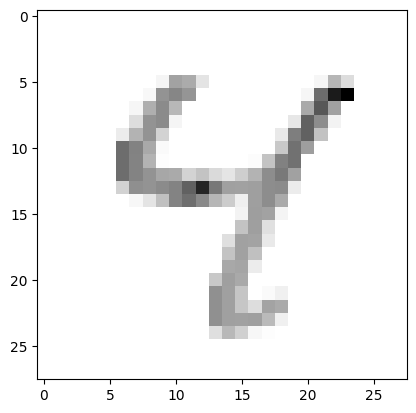

In [16]:
idx = 6
plt.imshow(x_test[idx])
print(np.argmax(predictions[idx]))
plt.imshow(x_test[idx],plt.cm.binary)

In [17]:
predictions

array([[1.0153160e-08, 1.8956079e-09, 2.8388481e-06, ..., 9.9999487e-01,
        2.8781639e-11, 2.7768280e-08],
       [1.0565983e-07, 6.3383467e-02, 9.3591553e-01, ..., 1.8424274e-09,
        5.9438543e-04, 9.4667669e-09],
       [3.3540053e-07, 9.9964678e-01, 3.4743025e-05, ..., 2.6524251e-05,
        2.5802833e-04, 9.9878332e-07],
       ...,
       [3.4425054e-09, 2.5226510e-07, 7.9783211e-09, ..., 5.6352383e-05,
        2.1260412e-06, 3.5863183e-04],
       [1.3712277e-06, 4.1958219e-07, 2.3879126e-08, ..., 3.8857149e-07,
        3.0100465e-04, 2.8077178e-09],
       [3.5063289e-07, 2.5518938e-07, 4.8183574e-07, ..., 3.1091038e-10,
        7.7834045e-07, 4.6918114e-09]], dtype=float32)

In [18]:
(x_train_new,y_train_new),(x_test_new,y_test_new) = mnist.load_data()

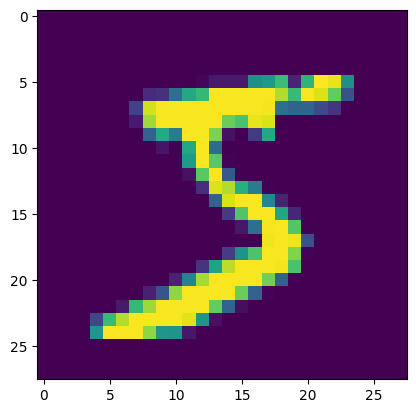

In [19]:
plt.imshow(x_train_new[0])

In [89]:
predictions = model.predict([x_test])
# model.predict([x_train[0]])
predictions.shape

(10000, 10)

0


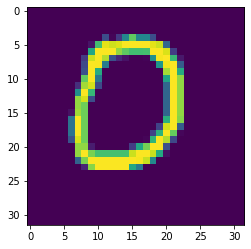

In [100]:
index = 10
plt.imshow(x_test[index])
print(np.argmax(predictions[index]))

In [23]:
with open('../data/digit_7.bin', 'wb') as f:
    f.write(x_test_new[0])

In [28]:
seven = x_test_new[0]

In [31]:
seven = np.pad(seven, [(0, 4), (0, 4)], mode='constant')

In [32]:
seven.shape

(32, 32)

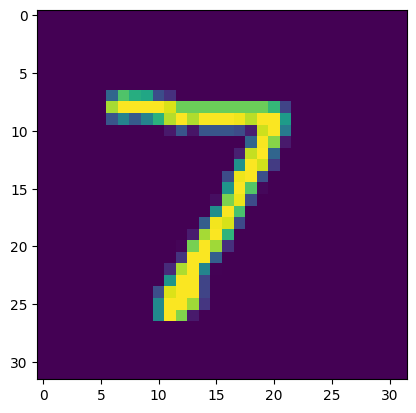

In [33]:
plt.imshow(seven)

In [34]:
with open('../data/digit_7.bin', 'wb') as f:
    f.write(seven)

In [107]:
! pip install tensorflow-model-optimization

ModuleNotFoundError: No module named 'tensorflow_model_optimization'